In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pandas as pd
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data_processed = pd.read_csv('tweets_preprocessed2.csv', on_bad_lines='skip')
non_suicide_data = data_processed[data_processed['class'] == 'non-suicide'].sample(n=4000)
suicide_data = data_processed[data_processed['class'] == 'suicide'].sample(n=4000)
balanced_data = pd.concat([non_suicide_data, suicide_data])

In [3]:
  >>> import nltk
  >>> nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Data Preprocessing

In [4]:
all_tokens = set(i.lower() for token in balanced_data["text"] for i in word_tokenize(token))
word_map = {token: idx for idx, token in enumerate(list(all_tokens))}
word_map['UNK'] = len(word_map)
word_map['PAD'] = len(word_map)+1

In [5]:
def text_encoder(sentence, word_map):
    tokens = word_tokenize(sentence.lower())
    encode = [word_map.get(token, word_map['UNK']) for token in tokens]
    return encode

In [6]:
class SuicideDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.vocab = vocab
        self.label_mapping = {
            'non-suicide': 0,
            'suicide': 1
        }
        self.labels = [self.label_mapping[label] for label in labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]
        encoded_sentence = text_encoder(sentence, self.vocab)

        return {
            'input_ids': torch.tensor(encoded_sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [7]:
# Pad the input_ids to the length of the longest sequence in the batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['label'] for item in batch]


    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=word_map['PAD'])
    labels = torch.stack(labels)
    text_lengths = torch.tensor([len(ids) for ids in input_ids], dtype=torch.long)

    return {
        'input_ids': padded_input_ids,
        'label': labels,
        'text_length': text_lengths
    }

In [8]:
# Split data
train_data, test_data, train_label, test_label = train_test_split(
    balanced_data['text'], balanced_data['class'], test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = SuicideDataset(train_data.to_numpy(), train_label.to_numpy(), word_map)
test_dataset = SuicideDataset(test_data.to_numpy(), test_label.to_numpy(), word_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## Binary-Classfication LSTM

In [9]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab_size+1,embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid() # use sigmoid as activation function

    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True, enforce_sorted=False)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        hidden = self.batch_norm(hidden)
        outputs=self.sigmoid(self.fc(self.dropout(hidden)))

        return outputs

In [10]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 2  # suicidal/non-suicidal
n_layers = 2
bidirectional = True
dropout = 0.3

In [11]:
model = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
def accuracy(preds, y):
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [13]:
def train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

def evaluate(model, loader, criterion):
    """
    Evaluate the model on the validation or test set.

    Parameters:
    - model: The trained LSTM model.
    - loader: DataLoader for the validation or test set.
    - criterion: Loss function (e.g., CrossEntropyLoss).

    Returns:
    - A dictionary containing accuracy, ROC AUC, and the confusion matrix.
    """
    model.eval()
    all_labels = []  # True labels
    all_preds = []   # Predicted labels
    all_probs = []   # Probabilities for the positive class

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in loader:
            input_ids = batch['input_ids'].to(device)  # Input data
            labels = batch['label'].to(device)         # True labels
            text_length = batch['text_length'].to(device)  # Sequence lengths

            # Get model predictions
            outputs = model(input_ids, text_length)

            # Collect true labels and predictions
            all_labels.extend(labels.cpu().numpy())             # True labels
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Predicted labels
            all_probs.extend(outputs[:, 1].cpu().numpy())       # Probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)  # Compute accuracy
    roc_auc = roc_auc_score(all_labels, all_probs)    # Compute ROC AUC
    cm = confusion_matrix(all_labels, all_preds)      # Compute confusion matrix

    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

In [15]:
EPOCH_NUMBER = 20
t_acc = []
t_loss = []
v_acc = []
roc = []
confusion = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train(model,train_loader,optimizer,criterion)

    result = evaluate(model,test_loader,criterion)

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(result['accuracy'])
    roc.append(result['roc_auc'])
    confusion.append(result['confusion_matrix'])

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Acc: {v_acc[-1]*100:.2f}%')
    print()

Epoch 1
	Train Loss: 0.541 | Train Acc: 76.31%
	Val. Acc: 80.19%

Epoch 2
	Train Loss: 0.494 | Train Acc: 81.38%
	Val. Acc: 83.88%

Epoch 3
	Train Loss: 0.500 | Train Acc: 80.42%
	Val. Acc: 83.56%

Epoch 4
	Train Loss: 0.447 | Train Acc: 86.08%
	Val. Acc: 84.94%

Epoch 5
	Train Loss: 0.422 | Train Acc: 88.59%
	Val. Acc: 84.88%

Epoch 6
	Train Loss: 0.405 | Train Acc: 90.44%
	Val. Acc: 81.19%

Epoch 7
	Train Loss: 0.397 | Train Acc: 91.36%
	Val. Acc: 89.94%

Epoch 8
	Train Loss: 0.383 | Train Acc: 92.84%
	Val. Acc: 88.69%

Epoch 9
	Train Loss: 0.374 | Train Acc: 93.81%
	Val. Acc: 85.62%

Epoch 10
	Train Loss: 0.365 | Train Acc: 94.77%
	Val. Acc: 89.31%

Epoch 11
	Train Loss: 0.355 | Train Acc: 95.61%
	Val. Acc: 88.94%

Epoch 12
	Train Loss: 0.355 | Train Acc: 95.69%
	Val. Acc: 90.00%

Epoch 13
	Train Loss: 0.354 | Train Acc: 95.84%
	Val. Acc: 90.06%

Epoch 14
	Train Loss: 0.349 | Train Acc: 96.42%
	Val. Acc: 89.12%

Epoch 15
	Train Loss: 0.346 | Train Acc: 96.67%
	Val. Acc: 89.25%

Epoc

In [16]:
print("The best validation accuracy:", round(max(v_acc), 2))

The best validation accuracy: 0.91


([<matplotlib.axis.XTick at 0x78b8f61174c0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

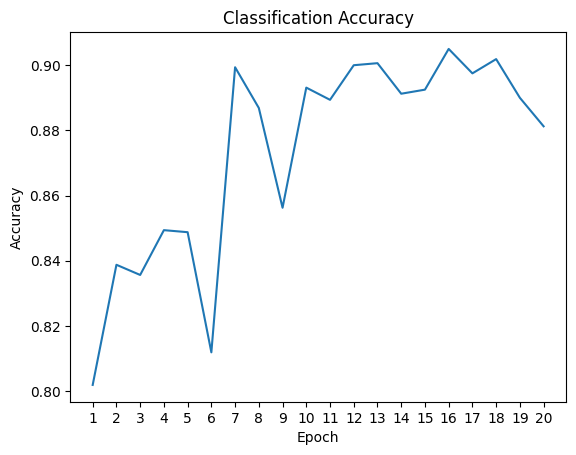

In [31]:
plt.plot(range(1, EPOCH_NUMBER+1), v_acc)
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, EPOCH_NUMBER+1))

([<matplotlib.axis.XTick at 0x78b8f628d0f0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

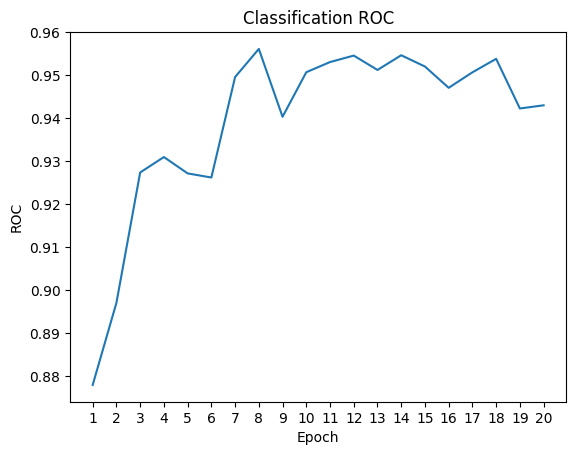

In [32]:
plt.plot(range(1, EPOCH_NUMBER+1), roc)
plt.title("Classification ROC")
plt.xlabel("Epoch")
plt.ylabel("ROC")
plt.xticks(range(1, EPOCH_NUMBER+1))

<Axes: >

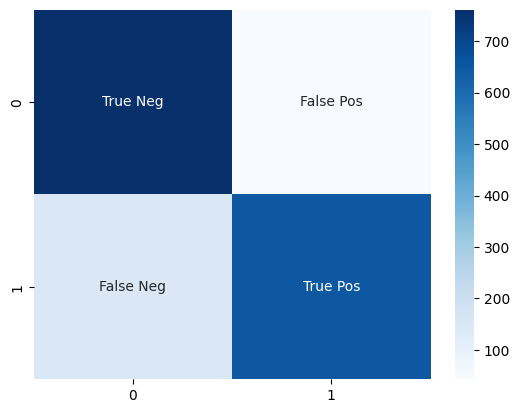

In [22]:
import seaborn as sns
import numpy as np
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion[-1], annot=labels, fmt='', cmap='Blues')

## Regression LSTM

In [10]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [11]:
regression = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(regression.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regression = regression.to(device)

In [12]:
def re_accuracy(preds, y, threshold=0.5):
    rounded_preds = (preds > threshold).float()  # Convert probabilities to binary predictions
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [13]:
def re_train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = re_accuracy(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
def re_evaluate(model, loader, criterion):
    """
    Evaluate the model on the validation or test set.

    Parameters:
    - model: The trained LSTM model.
    - loader: DataLoader for the validation or test set.
    - criterion: Loss function (e.g., CrossEntropyLoss).

    Returns:
    - A dictionary containing accuracy, ROC AUC, and the confusion matrix.
    """
    model.eval()
    all_labels = []  # True labels
    all_preds = []   # Predicted labels
    all_probs = []   # Probabilities for the positive class

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in loader:
            input_ids = batch['input_ids'].to(device)  # Input data
            labels = batch['label'].float().to(device)         # True labels
            text_length = batch['text_length'].to(device)  # Sequence lengths

            # Get model predictions
            outputs = model(input_ids, text_length).squeeze(1)

            # Collect true labels and predictions
            all_labels.extend(labels.cpu().numpy())             # True labels
            all_preds.extend(outputs.cpu().numpy())  # Predicted labels
            all_probs.extend((outputs>=0.5).cpu().numpy())       # Probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)  # Compute accuracy
    roc_auc = roc_auc_score(all_labels, all_probs)    # Compute ROC AUC
    cm = confusion_matrix(all_labels, all_preds)      # Compute confusion matrix

    return {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

In [21]:
26

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), re_v_acc)
plt.title("Regression Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), re_roc)
plt.title("Classification ROC")
plt.xlabel("Epoch")
plt.ylabel("ROC")

In [ ]:
import seaborn as sns
import numpy as np
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(re_confusion[-1], annot=labels, fmt='', cmap='Blues')

## Inference

### Binary Classfication

In [33]:
def predict_sentence(sentence, model, word_map, device):
    # Preprocess the sentence
    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Get the length of the input sentence (for packing sequence)
    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

    # Interpret the result
    if prediction == 0:
        return "The sentence is classified as Non-Suicidal."
    else:
        return "The sentence is classified as Suicidal."

In [34]:
sentence = "Every morning I wake up and I don't want to get out of bed. Eventually I do and when I look in the mirror, I hate how ugly I am. It makes me not want to exist. This is the main reason why I have social anxiety and I hate being out in public. I have no friends who I could talk to or hang out with. It feels like I'm not wanted by anyone. I hate living like this. I seriously consider suicide everyday. I have no friends or family that would care if I go. "
result = predict_sentence(sentence, model, word_map, device)
print(result)

The sentence is classified as Suicidal.


In [36]:
sentence = "Sometimes i need a hug So ill give myself one, because i deserve it"
result = predict_sentence(sentence, model, word_map, device)
print(result)

The sentence is classified as Non-Suicidal.


### Regression

In [ ]:
def regression_predict(sentence, model, word_map, device):

    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)

    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        probability = output.squeeze().item()  # Get the probability

    prediction = 1 if probability >= 0.5 else 0  # Threshold of 0.5
    if prediction == 0:
        result = f"The sentence is classified as Non-Suicidal with a probability of {1 - probability:.4f}."
    else:
        result = f"The sentence is classified as Suicidal with a probability of {probability:.4f}."

    return result

In [ ]:
sentence = "Every morning I wake up and I don't want to get out of bed. Eventually I do and when I look in the mirror, I hate how ugly I am. It makes me not want to exist. This is the main reason why I have social anxiety and I hate being out in public. I have no friends who I could talk to or hang out with. It feels like I'm not wanted by anyone. I hate living like this. I seriously consider suicide everyday. I have no friends or family that would care if I go. "
result = regression_predict(sentence, regression, word_map, device)
print(result)

The sentence is classified as Suicidal with a probability of 1.0000.


In [ ]:
sentence = "Sometimes i need a hug So ill give myself one, because i deserve it"
result = regression_predict(sentence, regression, word_map, device)
print(result)

The sentence is classified as Non-Suicidal with a probability of 0.9873.
